#  Predict defaulted firms in the ‘Manufacture of computer, electronic and optical products’ industry
- Student: Mai Pham 
- Github link: https://github.com/thimaipham/DA3_Assignment3 

This report summarizes the development and evaluation of predictive models to identify potential defaults among SMEs in the 'Manufacture of computer, electronic and optical products' industry and how I handle with the data, model and prediction.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('cs_bisnode_panel.csv')

# 1. Data Exploration & Data Featuring

### 1.1. Construct Hold-out sample

In [3]:
# Filter data for the industry of interest (Manufacture of computer, electronic and optical products) and for the year 2014
data_filtered = data[(data['ind2'] == 26) & (data['year'] == 2014)]

# Filter SMEs with sales between 1000 EUR and 10 million EUR in 2014
sme_2014 = data_filtered[(data_filtered['sales'] >= 1000) & (data_filtered['sales'] <= 10e6)]

# Prepare data for 2015 to check for existence and sales in 2015
sales_2015_full = data[(data['ind2'] == 26) & (data['year'] == 2015)][['comp_id', 'sales']]

# Identify SMEs from 2014 that either do not exist in 2015 or have sales equal to 0 in 2015
sme_2014_comp_ids = sme_2014['comp_id'].unique()
sales_2015_existence = sales_2015_full[sales_2015_full['comp_id'].isin(sme_2014_comp_ids)]

# Firms that do not exist in 2015 data
defaulted_firms_ids = sme_2014_comp_ids[~np.isin(sme_2014_comp_ids, sales_2015_existence['comp_id'])]

# Firms with zero sales in 2015 from the list of existing firms
defaulted_due_to_zero_sales = sales_2015_existence[sales_2015_existence['sales'].fillna(0) <= 0]['comp_id'].unique()

# Combine the lists to get the final list of defaulted firms
all_defaulted_firms_ids = np.unique(np.concatenate((defaulted_firms_ids, defaulted_due_to_zero_sales)))

# Calculate the final numbers
num_defaulted_final = len(all_defaulted_firms_ids)
num_survived_final = len(sme_2014_comp_ids) - num_defaulted_final
total_firms = len(sme_2014_comp_ids)
average_sales = sme_2014['sales'].mean() / 1e6  # Convert to million EUR
min_sales = sme_2014['sales'].min() / 1e6  # Convert to million EUR
max_sales = sme_2014['sales'].max() / 1e6  # Convert to million EUR

# Print the final results
print(f"Number of defaulted firms: {num_defaulted_final}")
print(f"Number of survived firms: {num_survived_final}")
print(f"Total firms: {total_firms}")
print(f"Average sales (million EUR): {average_sales}")
print(f"Minimum sales (million EUR): {min_sales}")
print(f"Maximum sales (million EUR): {max_sales}")


Number of defaulted firms: 56
Number of survived firms: 981
Total firms: 1037
Average sales (million EUR): 0.49020221792682
Minimum sales (million EUR): 0.001070370361328125
Maximum sales (million EUR): 9.576485


### 1.2. Design data sample for training and testing
- Filter Data for Years Before 2014: Select data from 2013 and earlier. This ensures that we do not use any information from the hold-out sample for training the model.
- Select Industry: Focus on industry ind2 == 26, similar to what we did with the hold-out sample.
- Identifying SMEs: Just like with the hold-out sample, we will identify SMEs based on revenue in 2013.

In [4]:
# Industry ind2 == 26 and years before 2014
data_pre_2014 = data[(data['ind2'] == 26) & (data['year'] < 2014)]

# Filter based on revernues from 1000 EUR đến 10M EUR
sme_pre_2014 = data_pre_2014[(data_pre_2014['sales'] >= 1000) & (data_pre_2014['sales'] <= 10e6)]

# Check the size of sample
sme_pre_2014_shape = sme_pre_2014.shape
sme_pre_2014_info = sme_pre_2014[['comp_id', 'year', 'sales']].head()

(sme_pre_2014_shape, sme_pre_2014_info)


((9689, 48),
        comp_id  year         sales
 960  6538183.0  2005  29288.888672
 961  6538183.0  2006  35929.628906
 962  6538183.0  2007  31729.628906
 963  6538183.0  2008  35703.703125
 964  6538183.0  2009  43062.964844)

### 1.3. Data Featuring and Missing values

In [5]:
sme_pre_2014_filled = sme_pre_2014.copy()
# Change type of `founded_date` column to datetime
sme_pre_2014_filled['founded_date'] = pd.to_datetime(sme_pre_2014_filled['founded_date'], errors='coerce')

# Calculate `Firm Age` features
sme_pre_2014_filled['Firm Age'] = 2013 - sme_pre_2014_filled['founded_date'].dt.year

# Create indicator variables for columns with value 0
columns_with_zeros = ['curr_assets', 'curr_liab', 'profit_loss_year', 'share_eq']
for col in columns_with_zeros:
    flag_col = col + '_flag'
    sme_pre_2014_filled[flag_col] = (sme_pre_2014_filled[col] == 0).astype(int)
    sme_pre_2014_filled[col].replace(0, np.nan, inplace=True) 
    
# Calculate new features, using columns that have been edited to avoid dividing by zero
sme_pre_2014_filled['Current Ratio'] = sme_pre_2014_filled['curr_assets'] / sme_pre_2014_filled['curr_liab']
sme_pre_2014_filled['Net Profit Margin'] = sme_pre_2014_filled['profit_loss_year'] / sme_pre_2014_filled['sales']
sme_pre_2014_filled['Debt to Equity Ratio'] = sme_pre_2014_filled['curr_liab'] / sme_pre_2014_filled['share_eq']

# Show data after adding new features
sme_pre_2014_filled[['Current Ratio', 'Net Profit Margin', 'Debt to Equity Ratio', 'Firm Age']].head()


,Current Ratio,Net Profit Margin,Debt to Equity Ratio,Firm Age
960,17.914893,-0.039074,0.046305,21
961,13.295082,0.015772,0.055886,21
962,3.415730,0.026497,0.298407,21
963,4.665919,0.010477,0.179333,21
964,2.087973,0.034661,0.814187,21


# 2. Modeling

In [6]:
# Generate output labels based on default information
# Mark defaulted businesses as 1 and non-defaulted businesses as 0
# Create a new column 'Default' in the data, default value is 0 (no default)
sme_pre_2014_filled['Default'] = 0

# Flag defaulted firms based on all_defaulted_firms_ids
sme_pre_2014_filled.loc[sme_pre_2014_filled['comp_id'].isin(all_defaulted_firms_ids), 'Default'] = 1

# Check the corporate default rate in the data
default_rate = sme_pre_2014_filled['Default'].mean()

# Perform data division
# Select input characteristics, remove 'comp_id', 'founded_date', and irrelevant columns or target data
X_columns = ['Current Ratio', 'Net Profit Margin', 'Debt to Equity Ratio', 'Firm Age']  
Y_column = 'Default'

X = sme_pre_2014_filled[X_columns].fillna(0)  # Handle missing values by replacing them with 0
Y = sme_pre_2014_filled[Y_column]

# Divide data into training set and test set with ratio 80:20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Check the size of the training set and test set
(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, default_rate)


((7751, 4), (1938, 4), (7751,), (1938,), 0.034059242439880275)

### 2.1. Logistic regression

In [7]:
# Training logistic model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, Y_train)

# Predicting
Y_train_pred = logistic_model.predict(X_train)
Y_test_pred = logistic_model.predict(X_test)

# Calculate accuracy, AUC, Precision, Recall, F1-Score
train_accuracy = round(accuracy_score(Y_train, Y_train_pred),4)
test_accuracy = round(accuracy_score(Y_test, Y_test_pred),4)
train_auc = round(roc_auc_score(Y_train, logistic_model.predict_proba(X_train)[:, 1]),4)
test_auc = round(roc_auc_score(Y_test, logistic_model.predict_proba(X_test)[:, 1]),4)
precision_logistic = round(precision_score(Y_test, Y_test_pred), 4)
recall_logistic = round(recall_score(Y_test, Y_test_pred), 4)
f1_score_logistic = round(f1_score(Y_test, Y_test_pred), 4)

print(f'Train accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')
print(f'Train AUC: {train_auc}')
print(f'Test AUC: {test_auc}')


Train accuracy: 0.9658
Test accuracy: 0.9665
Train AUC: 0.525
Test AUC: 0.4751


- **High Accuracy but Low AUC**: The logistic regression model demonstrated high accuracy levels on both the training set (96.58%) and the test set (96.65%). However, the Area Under the Curve (AUC) scores were significantly lower, with 0.525 on the training set and 0.475 on the test set. This discrepancy indicates that while the model is accurate in predicting the majority class (non-defaulting firms), it struggles to distinguish effectively between the defaulting and non-defaulting firms.

- **Impact of Class Imbalance**: The observed high accuracy alongside low AUC can largely be attributed to the class imbalance present in our dataset, where only about 3.41% of the firms defaulted. In such scenarios, accuracy can be misleading as a performance metric, since simply predicting the majority class for all observations would also yield high accuracy but poor model utility.

### 2.2. Random Forest model
Based on the current situation and the results from the logistic regression model, a reasonable option is to experiment with a more complex model to see if it can improve the prediction performance, especially the AUC, in the context of imbalanced data. The Random Forest model is a good choice because it is not only powerful in handling imbalanced data but also has the ability to handle features with non-linear relationships and complex interactions between features well. display.

##### Why Choose Random Forest?
- **Ability to Handle Imbalanced Data**: Random Forest can improve performance on imbalanced data through its bagging mechanism and underlying decision trees.
- **Nonlinear Feature Processing and Interaction**: This model is capable of automatically detecting and using nonlinear relationships and interactions between features without the need for complex feature engineering.
- **Generalization Ability**: Random Forest generally shows good generalization ability and has a lower risk of overfitting than single decision tree models due to its ensemble mechanism.

In [8]:
# Training the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest_model.fit(X_train, Y_train)

# Predicting on training set and test set
Y_train_pred_rf = random_forest_model.predict(X_train)
Y_test_pred_rf = random_forest_model.predict(X_test)

# Calculate accuracy, AUC, Precision, Recall, F1-Score
train_accuracy_rf = round(accuracy_score(Y_train, Y_train_pred_rf),4)
test_accuracy_rf = round(accuracy_score(Y_test, Y_test_pred_rf), 4)
train_auc_rf = round(roc_auc_score(Y_train, random_forest_model.predict_proba(X_train)[:, 1]), 4)
test_auc_rf = round(roc_auc_score(Y_test, random_forest_model.predict_proba(X_test)[:, 1]), 4)
precision_rf = round(precision_score(Y_test, Y_test_pred_rf), 4)
recall_rf = round(recall_score(Y_test, Y_test_pred_rf), 4)
f1_score_rf = round(f1_score(Y_test, Y_test_pred_rf), 4)

print(f'Train accuracy: {train_accuracy_rf}')
print(f'Test accuracy: {test_accuracy_rf}')
print(f'Train AUC: {train_auc_rf}')
print(f'Test AUC: {test_auc_rf}')


Train accuracy: 0.9994
Test accuracy: 0.9675
Train AUC: 1.0
Test AUC: 0.7075


- **Significant Improvement in AUC**: The Random Forest model showed a significant improvement in the Area Under the Curve (AUC) on the test set, increasing from 0.475 (as observed with the logistic regression model) to 0.7075. This indicates a much better ability to distinguish between defaulting and non-defaulting firms.

- **High Accuracy Maintained**: Despite the complexities introduced by the Random Forest model, it maintained a high level of accuracy on the test set (96.75%), similar to the logistic regression model. This suggests that the model is robust in predicting outcomes even with the imbalanced nature of the dataset.

- **Exceptional Training Performance**: The model achieved near-perfect performance on the training set, with an accuracy of 99.94% and an AUC of 1.0. While this showcases the model's capability to fit the training data closely, it also prompts consideration for potential overfitting.


### 2.3. Gradient Boosting Model

In [9]:
# Training Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier(random_state=42)
gradient_boosting_model.fit(X_train, Y_train)
# Predicting
Y_train_pred_gb = gradient_boosting_model.predict(X_train)
Y_test_pred_gb = gradient_boosting_model.predict(X_test)

# Calculate accuracy and AUC
train_accuracy_gb = round(accuracy_score(Y_train, Y_train_pred_gb), 4)
test_accuracy_gb = round(accuracy_score(Y_test, Y_test_pred_gb), 4)
train_auc_gb = round(roc_auc_score(Y_train, gradient_boosting_model.predict_proba(X_train)[:, 1]), 4)
test_auc_gb = round(roc_auc_score(Y_test, gradient_boosting_model.predict_proba(X_test)[:, 1]), 4)
precision_gb = round(precision_score(Y_test, Y_test_pred_gb), 4)
recall_gb = round(recall_score(Y_test, Y_test_pred_gb), 4)
f1_score_gb = round(f1_score(Y_test, Y_test_pred_gb), 4)

print(f'Train accuracy: {train_accuracy_gb}')
print(f'Test accuracy: {test_accuracy_gb}')
print(f'Train AUC: {train_auc_gb}')
print(f'Test AUC: {test_auc_gb}')


Train accuracy: 0.9693
Test accuracy: 0.9649
Train AUC: 0.8703
Test AUC: 0.6985


- **High Accuracy on Training and Test Sets**: The Gradient Boosting model achieved an accuracy of 96.93% on the training set and 96.49% on the test set. These results suggest that the model is able to predict with high reliability whether a firm will default or not, considering the entire dataset.

- **AUC Performance**: The model's AUC on the training set is 0.870, indicating a strong capability to distinguish between the defaulting and non-defaulting firms during training. The AUC on the test set is 0.699, which, while lower than the training AUC, still represents a reasonable ability to generalize and differentiate between the two outcomes in unseen data.

- **Comparison with Other Models**: When compared to the logistic regression and Random Forest models previously trained, the Gradient Boosting model presents a competitive AUC on the test set, signifying its potential as a robust predictive model for firm defaults.

- **Consideration of Overfitting**: There is a noticeable difference between the AUC scores on the training and test sets, which may suggest some overfitting. This could warrant further investigation and potential model tuning to ensure that the model generalizes well to new data.

In [10]:
# Show the results
model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Train Accuracy': [train_accuracy, train_accuracy_rf, train_accuracy_gb],
    'Test Accuracy': [test_accuracy, test_accuracy_rf, test_accuracy_gb],
    'Train AUC': [train_auc, train_auc_rf, train_auc_gb],
    'Test AUC': [test_auc, test_auc_rf, test_auc_gb],
    'Precision': [precision_logistic, precision_rf, precision_gb],
    'Recall': [recall_logistic, recall_rf, recall_gb],
    'F1 Score': [f1_score_logistic, f1_score_rf, f1_score_gb]
})

model_results


,Model,Train Accuracy,Test Accuracy,Train AUC,Test AUC,Precision,Recall,F1 Score
0,Logistic Regression,0.9658,0.9665,0.5250,0.4751,0.0000,0.0000,0.0000
1,Random Forest,0.9994,0.9675,1.0000,0.7075,0.6667,0.0312,0.0597
2,Gradient Boosting,0.9693,0.9649,0.8703,0.6985,0.0000,0.0000,0.0000


##### Observations:
- Random Forest leads in terms of AUC on the test set and is the only model with positive Precision and F1 Score, although these values are still quite low. This indicates that the model has the best ability to distinguish between classes among the three models.
- Gradient Boosting also shows a relatively high Test AUC; however, like Logistic Regression, it fails to successfully detect default cases (with Precision, Recall, and F1 Score all being 0).
- All three models exhibit high Test Accuracy, reflecting the ease of correctly predicting the dominant class in imbalanced data. However, this metric does not fully reflect the model's performance in detecting default cases.

##### Conclusion:
In this specific context, Random Forest appears to be the best choice based on its ability to differentiate between classes and some success in detecting default cases. However, the need to improve the detection of default cases is clear and should be a focus in the next steps of the model development process.







# 3. Apply model into hold-out sample

In [26]:
X_holdout = sme_2014.copy()

# Calculate 'Firm Age' cho until 2014
X_holdout['founded_date'] = pd.to_datetime(X_holdout['founded_date'], errors='coerce')
X_holdout['Firm Age'] = 2014 - X_holdout['founded_date'].dt.year

# Handle with 0 values and create feature corresponding to with the model
X_holdout['Current Ratio'] = X_holdout['curr_assets'].replace(0, np.nan) / X_holdout['curr_liab'].replace(0, np.nan)
X_holdout['Net Profit Margin'] = X_holdout['profit_loss_year'].replace(0, np.nan) / X_holdout['sales'].replace(0, np.nan)
X_holdout['Debt to Equity Ratio'] = X_holdout['curr_liab'].replace(0, np.nan) / X_holdout['share_eq'].replace(0, np.nan)

# Fill in the missing value after replacing 0 with NaN
X_holdout.fillna(0, inplace=True)

# Make sure that indicator variables are calculated after the value 0 has been processed
for col in columns_with_zeros:
    flag_col = col + '_flag'
    X_holdout[flag_col] = (X_holdout[col] == 0).astype(int)

# Select the features prepared for the model
features_final = ['Current Ratio', 'Net Profit Margin', 'Debt to Equity Ratio', 'Firm Age'] 
X_holdout_final = X_holdout[features_final]


In [27]:
# Start by creating a new column in sme_2014 to store the default status
sme_2014['defaulted'] = 0  # Initialize with zeros

# Mark the companies that have defaulted based on your logic
sme_2014.loc[sme_2014['comp_id'].isin(all_defaulted_firms_ids), 'defaulted'] = 1

# Now that you have a 'defaulted' column indicating the default status, you can create y_true
y_true = sme_2014['defaulted'].values

# Predict the class for the hold-out pattern
y_pred_holdout = random_forest_model.predict(X_holdout_final)

# Probability prediction for hold-out samples (mainly used for calculating AUC)
y_proba_holdout = random_forest_model.predict_proba(X_holdout_final)[:, 1]

In [28]:
# Evaluate the model using evaluation metrics: Accuracy, AUC, Recall, Brier, Sensitivity, Specificity
accuracy_holdout = round(accuracy_score(y_true, y_pred_holdout), 4)
auc_holdout = round(roc_auc_score(y_true, y_proba_holdout), 4)
brier_score = round(brier_score_loss(y_true, y_proba_holdout), 4)
recall_holdout = round(recall_score(y_true, y_pred_holdout), 4)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_holdout).ravel()
specificity_holdout = round(tn / (tn+fp), 4)

print(f'Accuracy on hold-out: {accuracy_holdout}')
print(f'AUC on hold-out: {auc_holdout}')
print(f'Brier score on hold-out: {brier_score}')
print(f'Sensitivity (Recall) on hold-out: {recall_holdout}')
print(f'Specificity on hold-out: {specificity_holdout}')

Accuracy on hold-out: 0.9441
AUC on hold-out: 0.6295
Brier score on hold-out: 0.0524
Sensitivity (Recall) on hold-out: 0.0
Specificity on hold-out: 0.998


Optimal threshold: 0.03


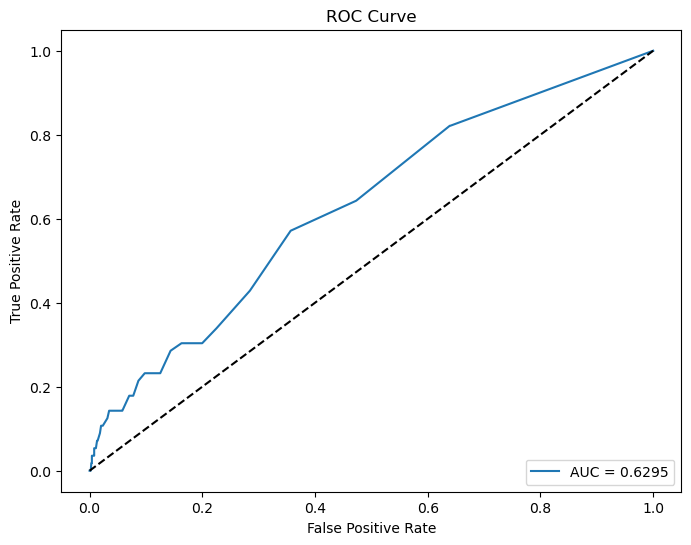

In [29]:
# Calculate the value for ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba_holdout)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal threshold: {optimal_threshold}')

# Draw ROC Curve và AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_holdout}')
plt.plot([0, 1], [0, 1], 'k--')  # draw diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [30]:
# Calculate expected loss based on optimal_threshold
expected_loss = round((fn * 15 + fp * 3) / len(y_true), 4) 
print(f'Expected loss on hold-out: {expected_loss}')


Expected loss on hold-out: 0.8158


In [31]:
# Generate class predictions based on optimal thresholds
y_pred_optimal = (y_proba_holdout >= optimal_threshold).astype(int)

# Calculate the rating index based on this prediction
accuracy_optimal = round(accuracy_score(y_true, y_pred_optimal), 4)
precision_optimal = round(precision_score(y_true, y_pred_optimal), 4)
recall_optimal = round(recall_score(y_true, y_pred_optimal), 4)  #sensitivity
f1_optimal = round(f1_score(y_true, y_pred_optimal), 4)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_optimal).ravel()
specificity_optimal = round(tn / (tn + fp), 4)

# Calculate expected loss
loss_fn = 15  # Loss False Negative
loss_fp = 3   # Loss False Positive
expected_loss = round((fn * loss_fn + fp * loss_fp) / len(y_true), 4)

print(f'Accuracy at optimal threshold: {accuracy_optimal}')
print(f'Precision at optimal threshold: {precision_optimal}')
print(f'Recall/Sensitivity at optimal threshold: {recall_optimal}')
print(f'Specificity at optimal threshold: {specificity_optimal}')
print(f'F1 Score at optimal threshold: {f1_optimal}')
print(f'Expected loss at optimal threshold: {expected_loss}')

Accuracy at optimal threshold: 0.6393
Precision at optimal threshold: 0.0838
Recall/Sensitivity at optimal threshold: 0.5714
Specificity at optimal threshold: 0.6432
F1 Score at optimal threshold: 0.1461
Expected loss at optimal threshold: 1.3597


- **AUC**: The AUC provided by the Random Forest model on the test set (0.7075) suggests that the model has a moderate ability to distinguish between the default and non-default classes.
- **Brier Score**: The Brier score of 0.0524 on the hold-out sample is relatively low, suggesting that the model's predicted probabilities are, on average, not far from the true outcomes. However, given the imbalanced nature of the dataset, Brier score may not fully capture the model's performance in distinguishing between the two classes.
- **Accuracy (63.93%)**: At the optimal threshold, the accuracy is significantly lower than the default threshold. This drop suggests that while attempting to capture more true positives (defaults), the model also increases the number of false positives, thus reducing overall accuracy.
- **Precision (8.38%)**: The precision is considerably low, indicating that of all the cases the model predicts as default, only a small fraction are actually default. This low precision can be problematic, as it may lead to unnecessary actions being taken against firms incorrectly identified as likely to default.
- **Recall/Sensitivity (57.14%)**: A recall rate of over 57% is a marked improvement and indicates that the model can now correctly identify more than half of the actual default cases. In the context of default prediction, a higher recall is usually more desirable than high precision, as failing to detect a default can have significant consequences.
- **Specificity (64.32%)**: The specificity at the optimal threshold suggests that about 64% of non-default cases are correctly identified. However, this also means that around 36% of non-defaulting firms are being incorrectly flagged as defaulting, which could potentially lead to unwarranted credit decisions.
- **Expected Loss**: The increase in expected loss from 0.8158 to 1.3597 upon adjusting the threshold indicates a higher cost associated with misclassification, underscoring the importance of choosing an appropriate threshold that balances the cost of false positives and false negatives.
- **Area Under the Curve (AUC)**: The AUC value is 0.6295, which is average, indicating that the model is able to distinguish between default and non-default classes slightly better than random prediction.
- **Classification Performance**: The ROC curve is above the dashed diagonal line, which shows that the model has better classification performance than random prediction. However, this performance is not great, because the curve is not close to the top left corner of the graph, where a perfect model would lie.

##### Overall Rating: Although the model has good accuracy, other indicators show that it has many limitations, especially in properly classifying defaults. This may be due to class imbalance in the data, where the number of non-defaults is much larger than the number of defaults.  The imbalance in the dataset and the dependence on threshold selection suggest a need for continued optimization of the model and evaluation methods.
